In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score

In [54]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [112]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', skiprows=1, thousands='.', decimal=',')[0]


In [113]:
df.head()

,0,1
0,13/05/2024,83.18
1,10/05/2024,83.39
2,09/05/2024,83.27
3,08/05/2024,82.44
4,07/05/2024,82.69


In [123]:
df = df.rename(columns={0:'Date',1:'Price'})
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11169 non-null  datetime64[ns]
 1   Price   11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


In [125]:
df.head()

,Date,Price
0,2024-05-13,83.18
1,2024-05-10,83.39
2,2024-05-09,83.27
3,2024-05-08,82.44
4,2024-05-07,82.69


In [130]:
df['Date'] = df['Date'].astype(str)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11169 non-null  object 
 1   Price   11169 non-null  float64
dtypes: float64(1), object(1)
memory usage: 174.6+ KB


In [133]:
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

In [134]:
df.head()

,Date,Price
0,13-05-2024,83.18
1,10-05-2024,83.39
2,09-05-2024,83.27
3,08-05-2024,82.44
4,07-05-2024,82.69


In [135]:
date_min = df['Date'].min()
date_max = df['Date'].max()

In [136]:
df.head()

,Date,Price
0,13-05-2024,83.18
1,10-05-2024,83.39
2,09-05-2024,83.27
3,08-05-2024,82.44
4,07-05-2024,82.69


In [137]:
df.to_excel('data.xlsx')

In [138]:
df.head()

,Date,Price
0,13-05-2024,83.18
1,10-05-2024,83.39
2,09-05-2024,83.27
3,08-05-2024,82.44
4,07-05-2024,82.69


In [139]:
df.to_csv('data.csv', index=False)

In [140]:
df2 = pd.read_csv('data.csv')

In [141]:
df2.head()

,Date,Price
0,13-05-2024,83.18
1,10-05-2024,83.39
2,09-05-2024,83.27
3,08-05-2024,82.44
4,07-05-2024,82.69


In [142]:
# Definindo a coluna 'A' como o índice
df = df.set_index('Date')

In [143]:
df.head()

,Price
Date,
13-05-2024,83.18
10-05-2024,83.39
09-05-2024,83.27
08-05-2024,82.44
07-05-2024,82.69


<Axes: xlabel='Date'>

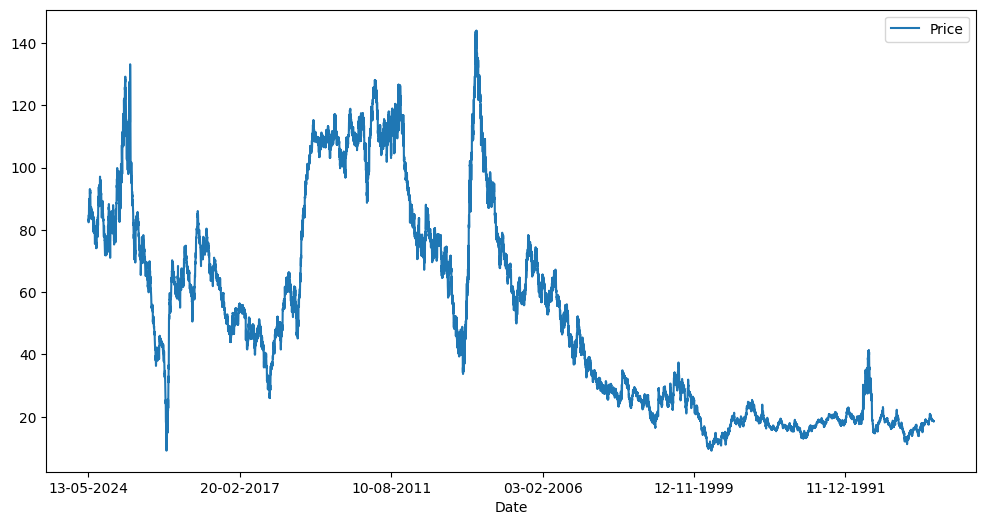

In [144]:
df.plot(figsize=(12,6))

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose

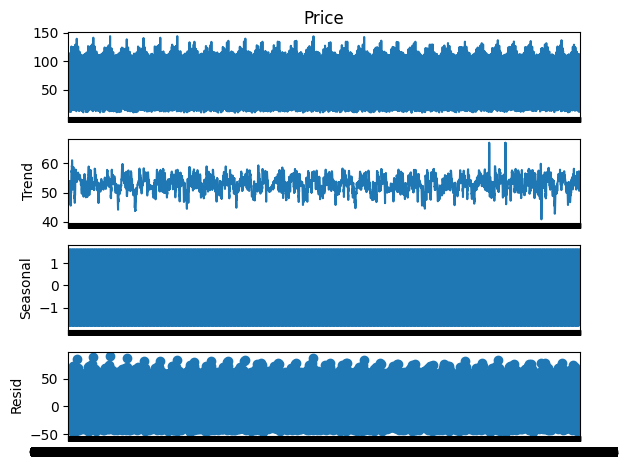

In [146]:
# Ordenando o índice de data em ordem crescente
df = df.sort_index()

results = seasonal_decompose(df['Price'],period=30)
results.plot();

In [147]:
# Filtrar o DataFrame para datas a partir de 01/01/2014
df = df.loc['2020-01-01':]

In [148]:
# Create additional features using the datetime index
#df['Day_of_week'] = df.index.dayofweek
#df['Month'] = df.index.month
#df['Year'] = df.index.year

df.head()

,Price
Date,
21-01-1988,17.08
21-01-1991,19.25
21-01-1992,17.85
21-01-1993,16.88
21-01-1994,14.23


In [149]:
len(df)

3796

In [150]:
train = df.iloc[:1091]
test = df.iloc[1091:]

In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [152]:
df.head(),df.tail()

(            Price
 Date             
 21-01-1988  17.08
 21-01-1991  19.25
 21-01-1992  17.85
 21-01-1993  16.88
 21-01-1994  14.23,
             Price
 Date             
 31-12-2016  53.93
 31-12-2017  66.73
 31-12-2019  67.77
 31-12-2020  51.22
 31-12-2021  77.24)

In [153]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaler.fit(test)
scaled_test = scaler.transform(test)

In [154]:
scaled_train[:10]

array([[0.06365963],
       [0.08101408],
       [0.06981766],
       [0.06206014],
       [0.04086692],
       [0.11084453],
       [0.0443858 ],
       [0.01615483],
       [0.14443378],
       [0.07357646]])

In [155]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [156]:
# define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [157]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.06365963 0.08101408 0.06981766 0.06206014 0.04086692]
Predict this y: 
 [[0.11084453]]


In [158]:
X.shape

(1, 5, 1)

In [159]:
# We do the same thing, but now instead for 12 months
n_input = 5
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [160]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [161]:
# Crie o modelo
#model = Sequential()
#model.add(LSTM(90, activation='sigmoid', input_shape=(n_input, n_features)))
#model.add(Dense(1))  # Mantenha a camada de saída
#model.compile(optimizer='adam', loss='mse')

In [162]:
# define model
model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

c:\Users\flade\Documents\GitHub\TECH3_PETROLEO\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [163]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
  73/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1400

c:\Users\flade\Documents\GitHub\TECH3_PETROLEO\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0577
Epoch 2/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0318
Epoch 3/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0293
Epoch 4/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0289
Epoch 5/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0300
Epoch 6/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0271
Epoch 7/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0272
Epoch 8/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0293
Epoch 9/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0244
Epoch 10/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0266
Epoch 11/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0273
Epoch 12/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0254
Epoch 13/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0238
Epoch 14/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0261
Epoch 15/50
1086/1086 ━━━━━━━━━━━━━━━━━━

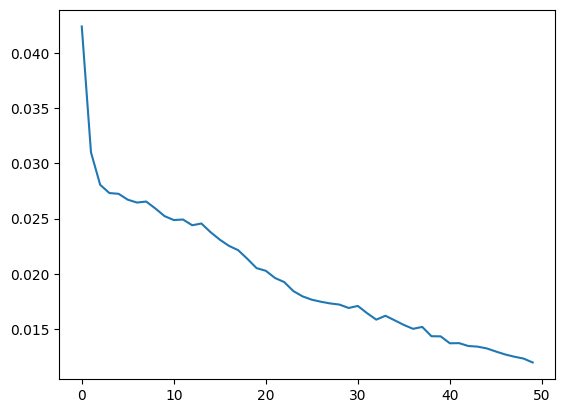

In [165]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [166]:
last_train_batch = scaled_train[-n_input:]

In [167]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [168]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


array([[0.10984008]], dtype=float32)

In [169]:
scaled_test[0]

array([0.10716256])

In [170]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [171]:
test_predictions

[array([0.10984008], dtype=float32),
 array([0.10605267], dtype=float32),
 array([0.10551825], dtype=float32),
 array([0.11375169], dtype=float32),
 array([0.1341895], dtype=float32),
 array([0.16850087], dtype=float32),
 array([0.21683253], dtype=float32),
 array([0.30889297], dtype=float32),
 array([0.46703178], dtype=float32),
 array([0.57102275], dtype=float32),
 array([0.683956], dtype=float32),
 array([0.6653559], dtype=float32),
 array([0.5641596], dtype=float32),
 array([0.55073553], dtype=float32),
 array([0.47994295], dtype=float32),
 array([0.48923132], dtype=float32),
 array([0.5772934], dtype=float32),
 array([0.6568035], dtype=float32),
 array([0.6426271], dtype=float32),
 array([0.5514029], dtype=float32),
 array([0.5106616], dtype=float32),
 array([0.4841094], dtype=float32),
 array([0.5211783], dtype=float32),
 array([0.62561285], dtype=float32),
 array([0.6515721], dtype=float32),
 array([0.5622153], dtype=float32),
 array([0.5012031], dtype=float32),
 array([0.491880

In [172]:
test.head(14)

,Price
Date,
23-12-1996,23.51
23-12-1997,17.09
23-12-1998,9.91
23-12-1999,25.11
23-12-2002,30.26
23-12-2003,31.03
23-12-2004,40.29
23-12-2005,56.09
23-12-2006,62.19


In [173]:
true_predictions = scaler.inverse_transform(test_predictions)

In [174]:
test['Predictions'] = true_predictions

C:\Users\flade\AppData\Local\Temp\ipykernel_23940\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

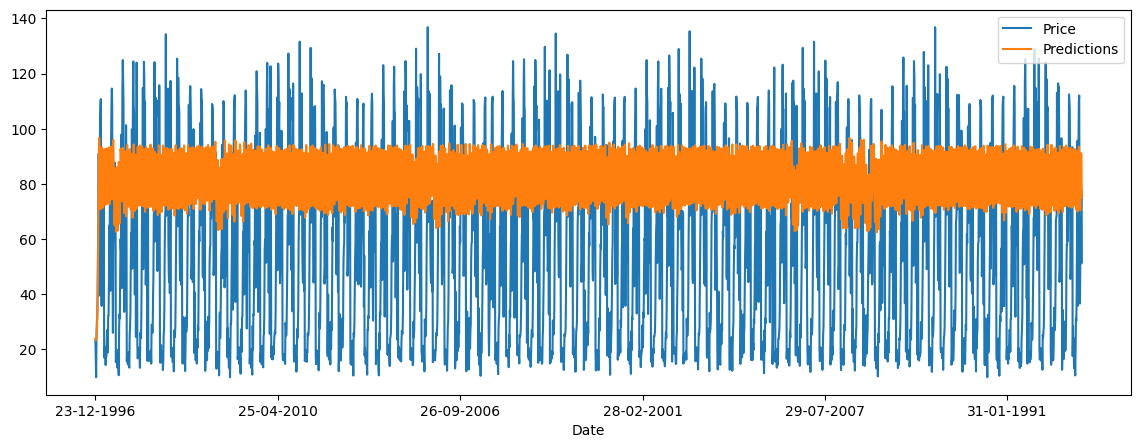

In [175]:
test.plot(figsize=(14,5))

In [176]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Price'],test['Predictions']))
print(rmse)

43.321976081455254


In [177]:
test.head()

,Price,Predictions
Date,,
23-12-1996,23.51,23.849805
23-12-1997,17.09,23.369144
23-12-1998,9.91,23.301321
23-12-1999,25.11,24.346228
23-12-2002,30.26,26.939990


In [178]:
# performance com 90 dias a partir de 2022> mae 3,27 mape 0,03 rmse 3,67
# performance com 10 dias a partir de 2020> mae 1,47 mape 0,017 rmse 1,90
# performance com 5 dias a partir de 2020> mae 2,19 mape 0,025 rmse 3,03
# parametros 
#model = Sequential()
#model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [179]:

lstm_performance = ml_error( "LSTM PERFORMANCE", test['Price'],test['Predictions'] )
lstm_performance

,Model Name,MAE,MAPE,RMSE
0,LSTM PERFORMANCE,37.453341,1.474525,43.321976
